In [7]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict

from utils import *

In [8]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [9]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Generalized Stitching Configs

In [10]:
def generalized_grouping_func(config):
    result = ''
    if config['agent']['is_td']:
        result += 'td'
    else:
        result += 'mc'

    if config['agent']['net_arch'] =='mlp':
        result += '_small'
    else:
        result += '_big'

    return result

agents = ['gcdqn', 'clearn_search']
grid_sizes = [4, 6]


for agent in agents:
    for grid_size in grid_sizes:

        config = {
            "title": f"{agent}_mc_vs_td_generalized_3_boxes_2_movable_{grid_size}_grid",
            "projects":["mc_vs_td_generalized"],
            "possible_names":['td_big', 'mc_big', 'td_small', 'mc_small'],
            "filters":{
                "config.agent.agent_name":agent,
                "config.env.grid_size": grid_size,
                "config.env.number_of_boxes_max":3,
                "config.env.number_of_moving_boxes_max":2,
            },
            "grouping_func": generalized_grouping_func,
            "metrics": OrderedDict([
                ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
                ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
            ]),
        }

        all_configs.append(config)


## Exact Stitching Configs

In [ ]:

def exact_grouping_func(config):
    result = ''
    if config['agent']['is_td'] or (not config['agent']['use_discounted_mc_rewards']):
        result += 'td'
    else:
        result += 'mc'

    if config['agent']['net_arch'] =='mlp':
        result += '_small'
    else:
        result += '_big'

    return result

agents = ['gcdqn', 'clearn_search']
grid_sizes = [4, 6]
box_nums = [1, 2, 3, 4]


for agent in agents:
    for grid_size in grid_sizes:
        for box_num in box_nums:

            config = {
                "title": f"{agent}_mc_vs_td_exact_{box_num}_boxes_{grid_size}_grid",
                "projects":["mc_vs_td_diagonal"],
                "possible_names":['td_big', 'mc_big', 'td_small', 'mc_small'],
                "filters":{
                    "config.agent.agent_name":agent,
                    "config.env.grid_size": grid_size,
                    "config.env.number_of_boxes_max":box_num,
                },
                "grouping_func": exact_grouping_func,
                "metrics": OrderedDict([
                    ("eval/mean_success", f"Training success on {box_num} boxes \n(adjacent quarters)"), 
                    ("eval_special/mean_success", f"Test success on {box_num} boxes \n(diagonal quarters)"),
                ]),
            }

            all_configs.append(config)

# Plotting

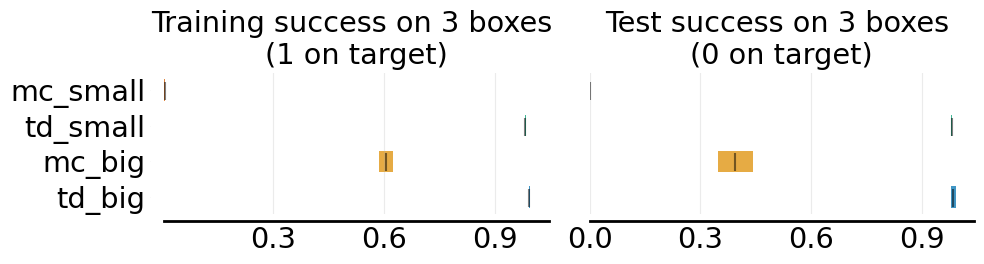

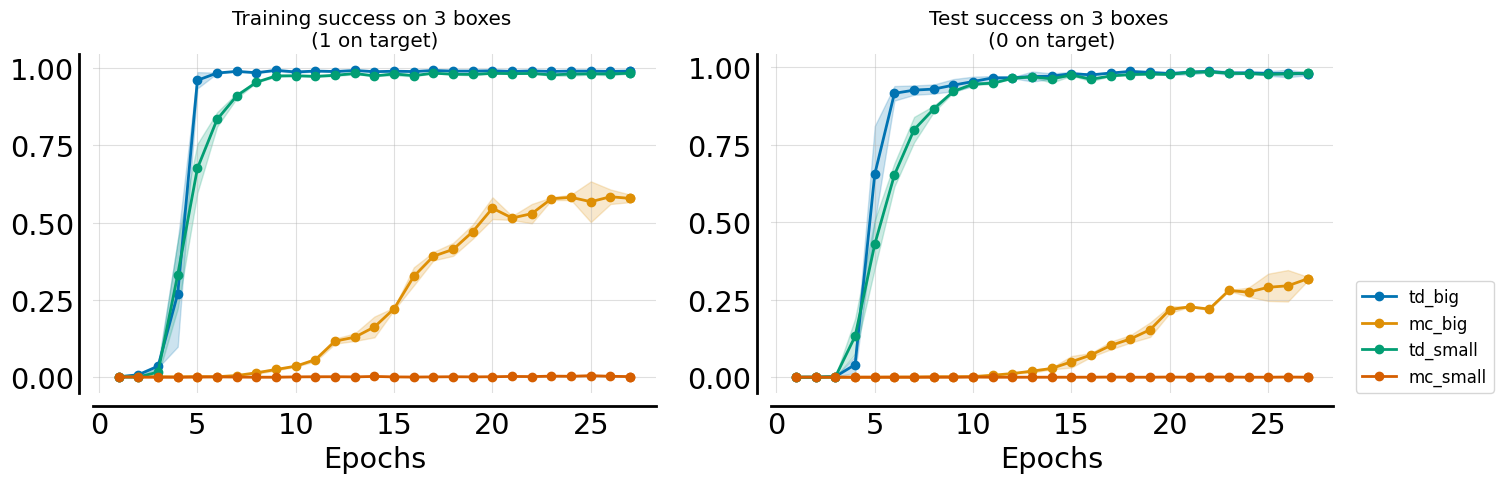

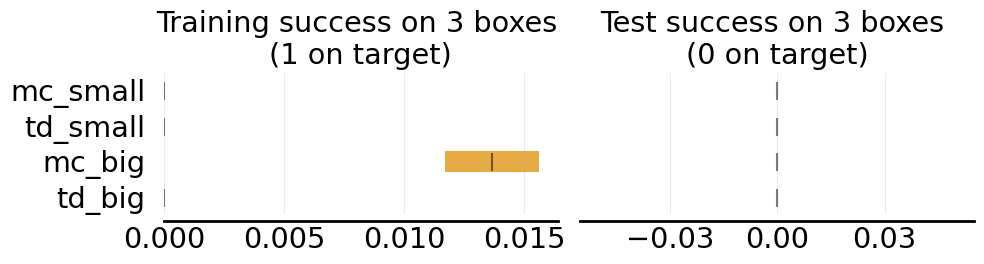

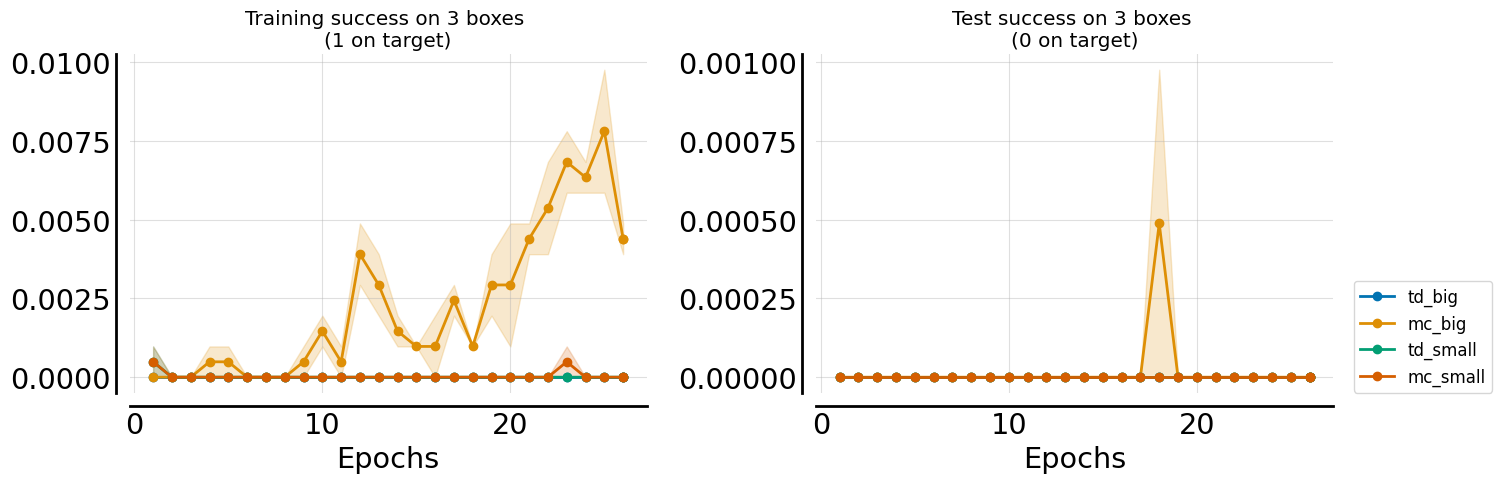

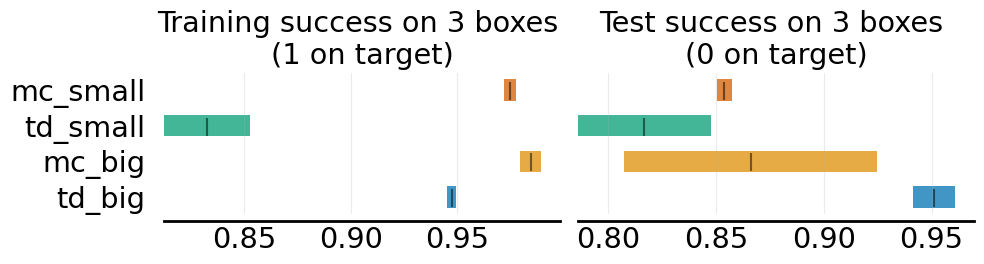

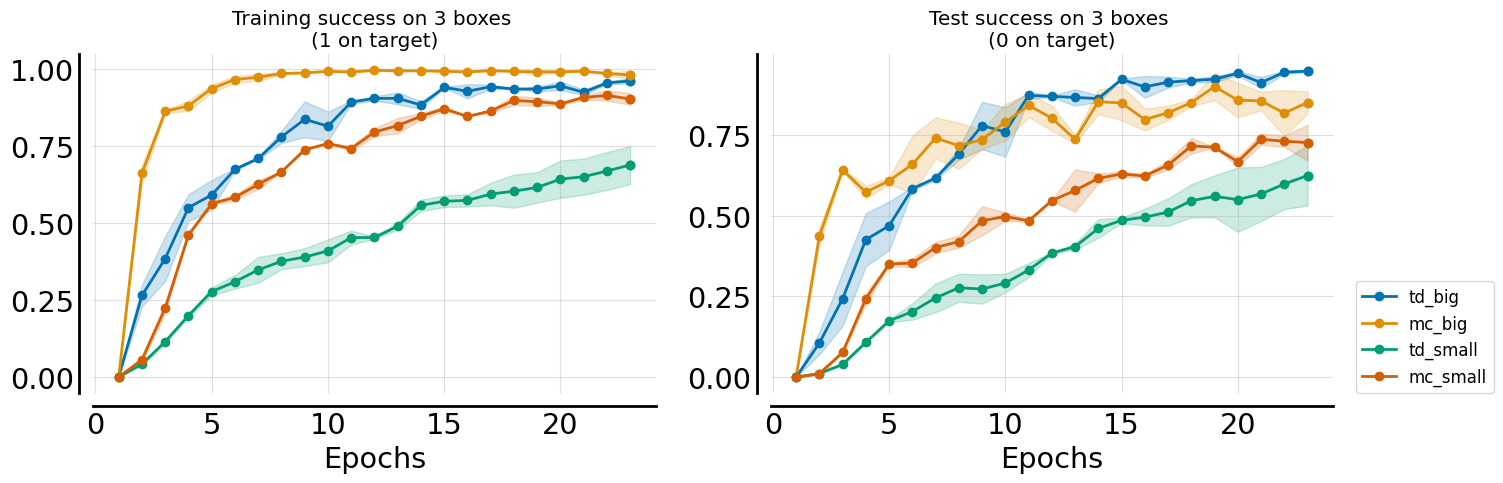

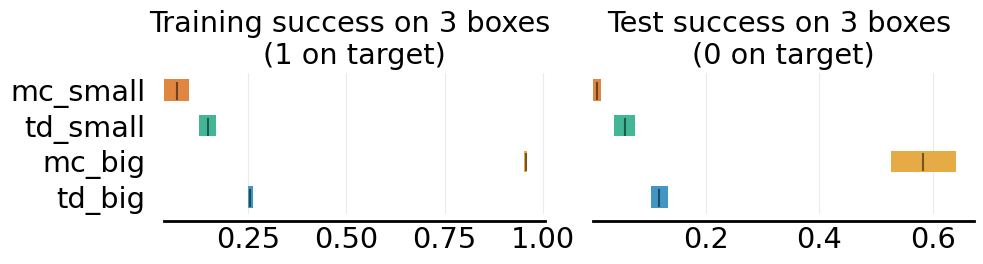

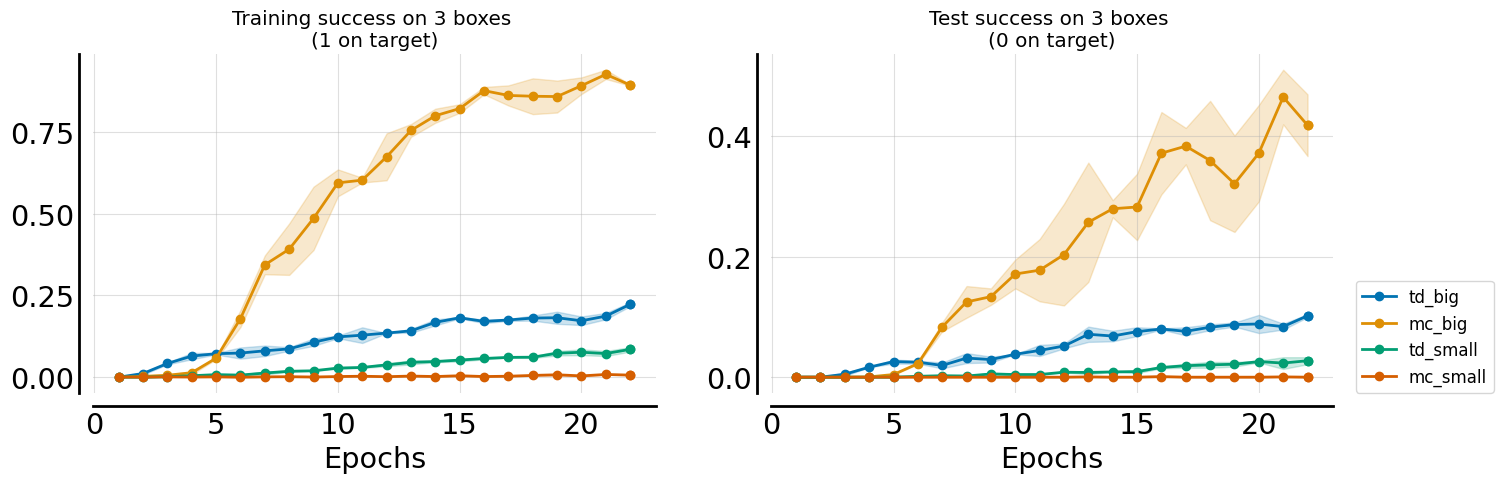

In [12]:
for config in all_configs:
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])


    data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)

    draw_interval_estimates_plot(data, config['possible_names'], config['metrics'], config['title'], figures_path=figures_path)
    draw_curves_plot(data_curves, config['possible_names'], config['metrics'], config['title'] + "_curves", figures_path=figures_path)